In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler # Normalization용

In [10]:
# data 불러오기
df_price = pd.read_csv(os.path.join('', '01-삼성전자-주가.csv'), encoding='utf8')
df_price.describe()

,일자,시가,고가,저가,종가,거래량
count,9.288000e+03,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,2.001347e+07,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,1.015376e+05,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,1.985010e+07,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,1.992121e+07,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,2.001032e+07,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,2.010080e+07,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,2.020011e+07,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


In [11]:
# 날짜 datetime 포맷으로 변환
pd.to_datetime(df_price['일자'], format='%Y%m%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['연도'] =df_price['일자'].dt.year
df_price['월'] =df_price['일자'].dt.month
df_price['일'] =df_price['일자'].dt.day

In [12]:
# 컬럼은 [일자, 시가, 고가, 저가, 종가, 거래량]으로 구성된 매우 단순한 데이터 셋
# 총 9,288개의 row로 구성되어 있네요. 우리는 일자, 시가, 고가, 저가, 거래량을 
# 토대로 미래의 주가인 "종가"를 예측해 보도록 하겠습니다.
df_price

,일자,시가,고가,저가,종가,거래량,연도,월,일
0,2020-01-07,55700,56400,55600,55800,9893846,2020,1,7
1,2020-01-06,54900,55600,54600,55500,10278951,2020,1,6
2,2020-01-03,56000,56600,54900,55500,15422255,2020,1,3
3,2020-01-02,55500,56000,55000,55200,12993228,2020,1,2
4,2019-12-30,56200,56600,55700,55800,8356767,2019,12,30
...,...,...,...,...,...,...,...,...,...
9283,1985-01-09,126,126,122,123,324836,1985,1,9
9284,1985-01-08,129,129,127,127,845098,1985,1,8
9285,1985-01-07,129,130,128,129,771895,1985,1,7
9286,1985-01-05,129,129,128,128,108496,1985,1,5


Text(0, 0.5, 'price')

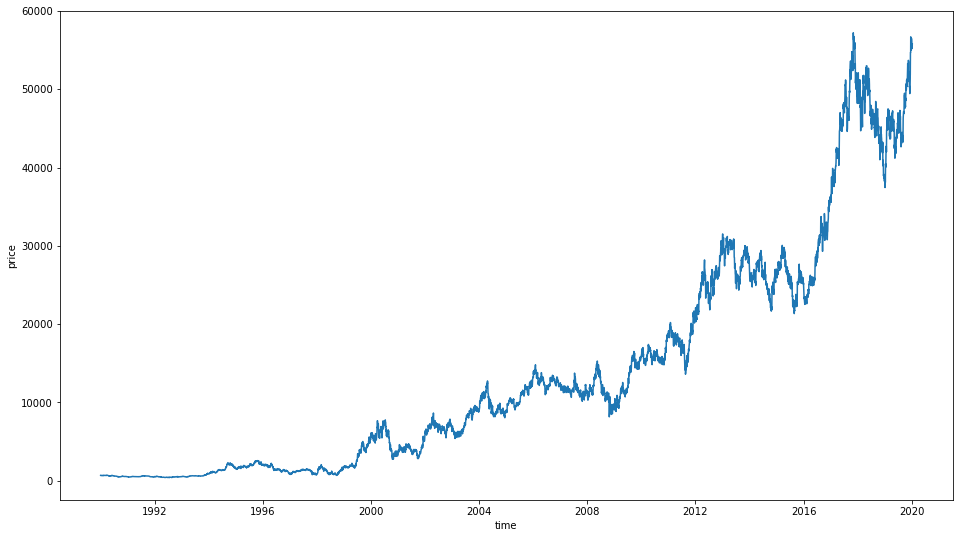

In [13]:
# 1990년도 이후의 주가 시각화
df = df_price.loc[df_price['연도']>=1990]

plt.figure(figsize=(16, 9))
sns.lineplot(y=df['종가'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

In [15]:
# Normalization
# 딥러닝 모델이 학습을 잘하기 위해서는 정규화 해주는 작업이 필요함
# sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalize 해 주도록 하겠습니다.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

# MinMaxScaler를 해주면 전체 데이터는 0, 1사이의 값을 갖도록 해줍니다.
df_scaled

,시가,고가,저가,종가,거래량
0,0.968482,0.980394,0.979423,0.975012,0.030291
1,0.954474,0.966389,0.961684,0.969733,0.031470
2,0.973735,0.983895,0.967005,0.969733,0.047217
3,0.964980,0.973391,0.968779,0.964454,0.039781
4,0.977237,0.983895,0.981197,0.975012,0.025585
...,...,...,...,...,...
7823,0.005095,0.005094,0.005073,0.004927,0.002960
7824,0.005165,0.005129,0.005215,0.005068,0.005279
7825,0.005236,0.005199,0.005162,0.005015,0.005483
7826,0.005236,0.005339,0.005286,0.005279,0.008384


In [22]:
# 학습을 시킬 데이터 셋 생성
TEST_SIZE = 200
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [23]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [24]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

In [25]:
train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

((6086, 20, 4), (1522, 20, 4))

In [26]:
# test dataset (실제 예측 해볼 데이터)
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((180, 20, 4), (180, 1))

In [30]:
!pip install keras
!pip install tensorflow

  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=c470722d0e56952a6ea13fb6eb7c4a9417e1f5610b21a1283a9f87903ccd3c01
  Stored in directory: c:\users\anwhr\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor
  Attempting uninstall: h5py
    Found existing installation: h5py 3.2.1
    Uninstalling h5py-3.2.1:
      Successfully uninstalled h5py-3.2.1


In [31]:
# ## Keras를 활용한 LSTM 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

In [32]:
model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [34]:
model_path = '_model/'

In [35]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

# ...
# ...

# Epoch 00015: val_loss did not improve from 0.00002
# Epoch 16/200
# 6086/6086 [==============================] - 12s 2ms/step - loss: 3.1661e-05 - val_loss: 4.1063e-05

# Epoch 00016: val_loss did not improve from 0.00002
# Epoch 17/200
# 6086/6086 [==============================] - 13s 2ms/step - loss: 2.4644e-05 - val_loss: 4.0085e-05

# Epoch 00017: val_loss did not improve from 0.00002
# Epoch 18/200
# 6086/6086 [==============================] - 13s 2ms/step - loss: 2.2936e-05 - val_loss: 2.4692e-05

# Epoch 00018: val_loss did not improve from 0.00002

Epoch 1/200
381/381 [==============================] - 4s 6ms/step - loss: 0.0187 - val_loss: 5.2511e-05

Epoch 00001: val_loss improved from inf to 0.00005, saving model to _model\tmp_checkpoint.h5
Epoch 2/200
381/381 [==============================] - 2s 5ms/step - loss: 5.2587e-05 - val_loss: 6.2326e-05

Epoch 00002: val_loss did not improve from 0.00005
Epoch 3/200
381/381 [==============================] - 2s 5ms/step - loss: 5.7125e-05 - val_loss: 4.4959e-05

Epoch 00003: val_loss improved from 0.00005 to 0.00004, saving model to _model\tmp_checkpoint.h5
Epoch 4/200
381/381 [==============================] - 2s 6ms/step - loss: 5.0854e-05 - val_loss: 5.5130e-05

Epoch 00004: val_loss did not improve from 0.00004
Epoch 5/200
381/381 [==============================] - 2s 6ms/step - loss: 5.0534e-05 - val_loss: 3.9093e-05

Epoch 00005: val_loss improved from 0.00004 to 0.00004, saving model to _model\tmp_checkpoint.h5
Epoch 6/200
381/381 [==============================] - 2s 6ms/ste

In [36]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

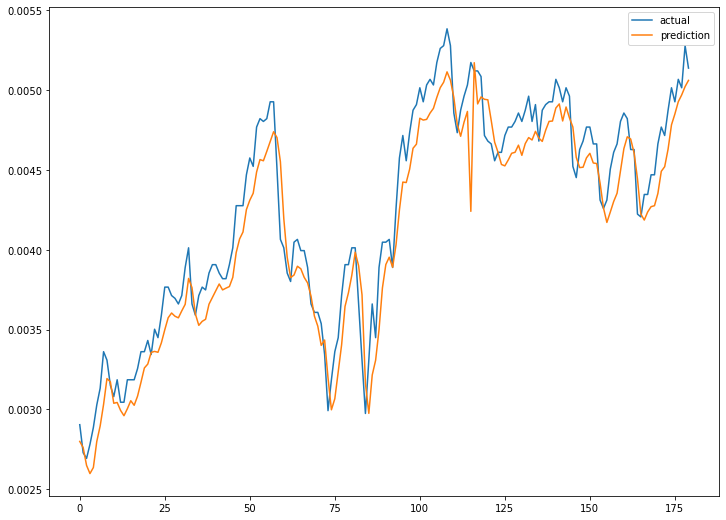

In [37]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()